In [1]:
import numpy as np
import pandas as pd
from PIL import Image
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io
from scipy.cluster.hierarchy import linkage,dendrogram

In [163]:
def get_dim(Im):
    """Takes an image as an input and gives dimensions for pixels (width and height)"""
    return Image.open(Im).size

In [164]:
def get_xy(Im):
    """Take an image and return all possible (x,y) coordinate combinations"""
    width, height = Image.open(Im).size
    return list(product(np.arange(width),np.arange(height)))

In [165]:
def get_rgb(Im):
    """Take an image and return rgb values for every pixel"""
    im = Image.open(Im) 
    pix = im.load()
    rgb = [pix[i,j] for i,j in get_xy(Im)]
    return rgb

In [166]:
def get_data(Im):
    """Take an image and extract all the coordinates and RGB values of each pixel. Returns a data frame 
    containing that information"""
    img_data = list(zip(get_xy(Im),get_rgb(Im)))
    df = []
    for i in img_data:
        columns = {'x':i[0][0],'y':i[0][1],'Red':i[1][0],'Green':i[1][1],'Blue':i[1][2]}
        df.append(columns)
    return pd.DataFrame(df)

In [167]:
def conditional_values(C,D, picture):
    """This is to get the conditional entropy between two colors in an image. Returns the conditional entropy
    C: First color
    D: Second Color
    Picture: DataFrame
    """
    P_c_d_joint = picture[[C,D]].value_counts()/len(picture) #to get the probability of each pixel
    df_P_c_d_joint = P_c_d_joint.sort_index().to_frame().reset_index() #made it a dataframe to make the math easier 
    Prob_of_C = picture[C].value_counts()/len(picture) # to get the probability of this color
    H_C = -np.sum(Prob_of_C*np.log10(Prob_of_C))  #to get the entropy of color C 
    Prob_of_D = picture[D].value_counts()/len(picture) # to get the probability of this color 
    Prob_of_D_dict = Prob_of_D.sort_index().to_frame().to_dict()[D] #calling a dictionary to get the correct probability as it is
    #in this color
    df_P_c_d_joint['Prob of D'] = df_P_c_d_joint[D].apply(lambda x: Prob_of_D_dict.get(x)) #getting every value of the dictionary
    #connecting to the right pixel
    df_P_c_d_joint.columns = [C,D,'Joint Prob of C and D','Prob of D'] #renaming the columns to the appropriate name
    P_C_given_D = df_P_c_d_joint['Joint Prob of C and D']/df_P_c_d_joint['Prob of D'] #getting the conditional prob of C given D
    H_C_given_D = -np.sum(df_P_c_d_joint['Joint Prob of C and D']* np.log10(P_C_given_D)) #getting the correct H(C|D) values
    HR_C_given_D = H_C_given_D/H_C # getting the correct conditional entropy between C given D 
    return HR_C_given_D

In [204]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
def conditional_entropy_map(df, color, plot_title):
    """Helps to create the conditional entropy heatmap for the RGB for an image. Returns the conditional entropy heatmap
    df: dataframe of the RGB values, should be a pandas dataframe
    color: color of the cmap for seaborn heatmap, should be a string
    plot_title: title of the seaborn heatmap, should be a string
    """
    #uses the function above
    RE_BL = conditional_values('Red','Blue', df) #conditional entropy between red and blue
    RE_GR = conditional_values('Red','Green', df)  #conditional entropy between red and green
    BL_RE = conditional_values('Blue','Red', df) #conditional entropy between blue and red
    BL_GR = conditional_values('Blue','Green', df) #conditional entropy between blue and green
    GR_RE = conditional_values('Green','Red', df) #conditional entropy between green and red
    GR_BL = conditional_values('Green','Blue', df) #conditional entropy between green and blue 
    #diagonals are 0 because it is conditional entropy on itself
    #making the dataframe to make the heatmap from based on the conditional above with the indexes and columns
    correlation_map = pd.DataFrame([[0, RE_GR, RE_BL], [GR_RE, 0, GR_BL], [BL_RE, BL_GR, 0]], 
                                   index = ['Red','Green','Blue'],
                                   columns = ['Red','Green','Blue']) 
    correlation_heatmap = sns.heatmap(correlation_map,annot = True,fmt='.3g', 
                                      cmap = color).set(title = plot_title)
    return correlation_heatmap

[Text(0.5, 1.0, 'Conditional Entropy of Red MM Painting')]

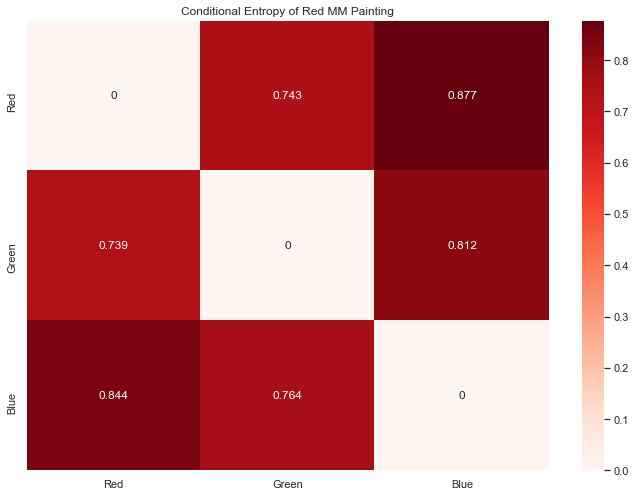

In [205]:
#Getting the red image data and making heatmap 
red_df = get_data('Red.png')
conditional_entropy_map(red_df, 'Reds', 'Conditional Entropy of Red MM Painting')

When looking at the Conditional Entropy heatmap for Red MM Painting, noticeably all the combination of RGB are all relatively high (above 0.5) meaning that they are somewhat independent of each other and not determine by one another. When comparing the red color channel to the green color channel, it is at 0.743 meaning that red cannot predict green as they are moreso independent from one another. The highest conditional entropy is between red and blue and blue and red indicating that they are very independent from one another and cannot predict one another with high accuracy. This make sense as they also have low correlation with one another and red and blue do not go hand in hand in colors as red should be the more prominent color in the Red MM painting. However, green and red and red and green have one of the lowest conditional entropies for the red MM painting and they have a relatively mid correlation with one another. The only time they are used together for the yellow/golden hair which allows red/green combination to be predictable with one another. 

[Text(0.5, 1.0, 'Conditional Entropy of Orange MM Painting')]

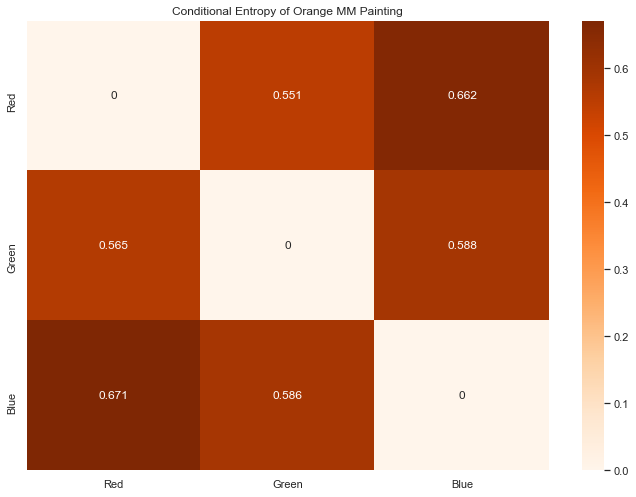

In [206]:
#Getting the orange image data and making heatmap 
orange_df = get_data('ORANGE.png')
conditional_entropy_map(orange_df, 'Oranges', 'Conditional Entropy of Orange MM Painting')

When looking at the Conditional Entropy heatmap for orange MM painting, noticeably all the conditional entropies of the colors are relatively high meaning that they are somewhat independent of each other and one color cannot give information about another color. However, since orange is a mix of colors, the conditional entropies for all the colors will be somewhat lower than the other conditional entropies plot for the other painting as orange is a mixture of green and red. Red and green and green and red have a conditional entropy of 0.551 and 0.565 respectively indicating that they are somewhat independent but the lower entropy could be because of the combination of red and green to make yellow and then the red and yellow to make the orange background. This can be supported by the orange MM painting correlation plot as red and green and green and red correlations is very high. However, red and blue and blue and red have the highest conditional entropies at 0.662 and 0.671 which make sense as red and blue should not be able to predict one another since the primary color being used here is orange that does not involve blue and red and blue combinations are not a majority proponent of the painting. 


[Text(0.5, 1.0, 'Conditional Entropy of Green MM Painting')]

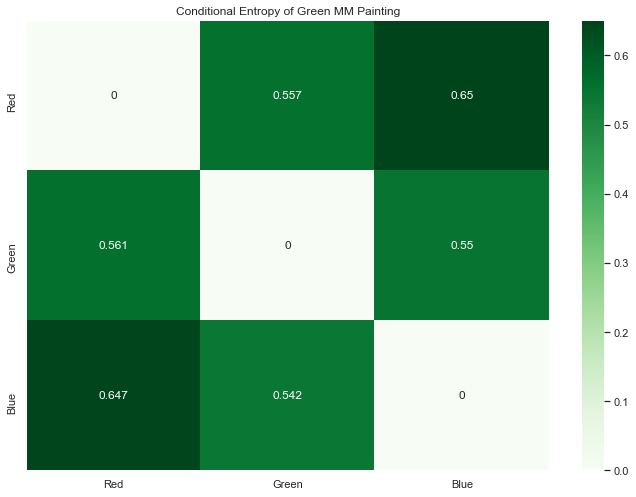

In [211]:
#Getting the green image data and making heatmap 
green_df = get_data('GREEN.png')
conditional_entropy_map(green_df, 'Greens', 'Conditional Entropy of Green MM Painting')

When looking at the conditional entropy heatmap for green MM painting, an assumption of green and blue and blue and green should be the lowest conditional entropy out of all color combination since the background of the green MM painting is turquoise. Since the background is turquoise, the colors of blue and green combined to make turquoise indicating that they can somewhat predict one another as when blue is used, green could potentially be used to make the background. Regardless of this information, green and blue and blue and green have a conditional entropy of 0.55 and 0.542, respectively. They are the lowest conditional entropy indicating that they are the most related to one another but they are still independent as it is closer to 1 than 0. Red and blue and blue and red have the highest conditional entropy indicating independence and not much prediction can be made by knowing one of the color channel in this case, they are at 0.65 and 0.647, respectively. Red and green and green and red are between the two conditional entropy set of red and blue and green and blue, as they are at 0.557 and 0.561 respectively. The values of red and green cannot be predicted as well comparatively to blue and green but not as unpredictable as red and blue as noted by their conditional entropies. 

[Text(0.5, 1.0, 'Conditional Entropy of Aqua MM Painting')]

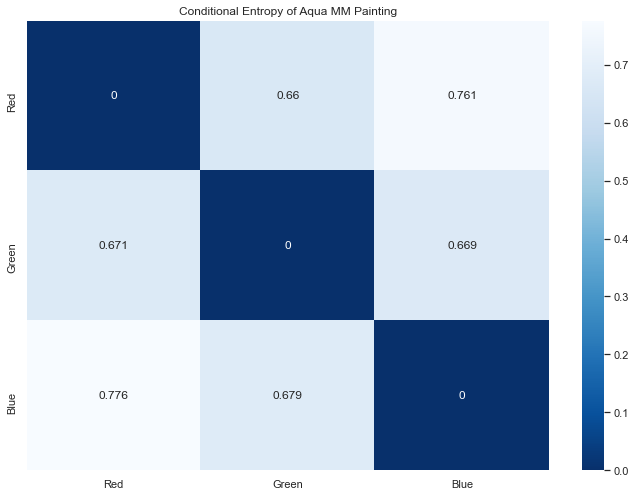

In [210]:
#Getting the aqua image data and making heatmap 
aqua_df = get_data('AQUA.png')
conditional_entropy_map(aqua_df, 'Blues_r', 'Conditional Entropy of Aqua MM Painting')

When looking at the conditional entropy heatmap for the aqua MM painting, red and blue and blue and red have the highest conditional entropy meaning they are the most independent colors in the painting. They have a conditional entropy of 0.761 and 0.776, respectively. The conditional entropy between the red and blue combination is logical because in the aqua painting, the color that is prominent is blue and to keep it blue, red is not needed thus not able to predict when blue and independent of red. While red and green and green and red have a conditional entropy of 0.66 and 0.671, respectively. They are the midpoint of conditional entropies of all color combinations and they are not correlated with one another well and not able to predict one another at high accuracies. The green and blue and blue and green have a conditional entropy of 0.669 and 0.679, respectively. The overall color composition and relationships within the image is not predictable at high accurate since all the conditional entropies are above 0.5 meaning somewhat independence. 

[Text(0.5, 1.0, 'Conditional Entropy of Blue MM Painting')]

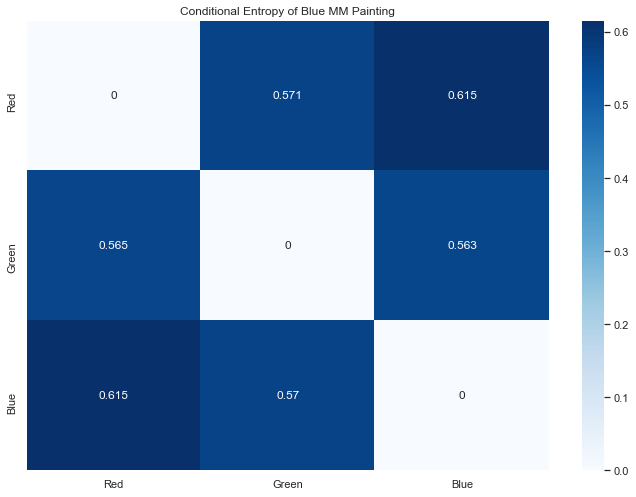

In [209]:
#Getting the blue image data and making heatmap 
blue_df = get_data('BLUE.jpeg')
conditional_entropy_map(blue_df, 'Blues', 'Conditional Entropy of Blue MM Painting')

When looking at the conditional entropy heatmap for the blue MM painting, shockingly the red and blue and blue and red have one of the lower conditional entropies of all paintings as they have a conditional entropy of 0.615 and 0.615, respectively. The reason why in the blue MM painting the conditional entropies of red and blue and blue and red are the lowest out of all other paintings because of the color of the skin in this MM painting as it is a darker shade of magneta. Magneta is a combination of blue and red and thus allows for some correlation between the two. However, the conditional entropy is still above 0.5 and thus somewhat independent and cannot be used to predict one another. The conditional entropy for red and green, green and red, green and blue, and blue and green all have similar conditional entropy at 0.571, 0.565, 0.563, and 0.57 respectively. All that indicates is independence from one another and low accurate for predictability among the color channels since all the conditional entropies are above 0.5 and independent. 

The most noticeable thing about the conditional entropy in each painting is how red and blue and blue and red are the conditional entropies that are the highest compared to the other combinations of color channel indicating that red and blue does not provide enough information of each other. Additionally, in the red MM painting had the highest conditional entropies for all combination of colors due to the fact how red is the most prominent color and does not necessarily need blue or green when making that painting.